# Assignment 2
Comparison of the exponential and running mean for random walk model

### Team members:

Zakhar Yagudin, Skoltech, 2023 <br>
CRediT author statement: Software (lead), Formal analysis

Khasan Akhmadiev, Skoltech, 2023 <br>
CRediT author statement: Writing - original draft, Validation

Konstantin Zamansky, Skoltech, 2023 <br>
CRediT author statement: Visualization, Software, Writing - review & editing

https://beta.elsevier.com/researcher/author/policies-and-guidelines/credit-author-statement?trial=true

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import Image

pd.options.plotting.backend = 'plotly'

# Part I

### Generating true trajectory and measurements

Firstly, a true trajectory is generated by using the random walk model:<br>
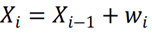 <br>
w<sub>i</sub> - normally distributed random noise with zero mathematical expectation and variance equals to 20, <br>
with initial condition X<sub>1</sub> = 10

In [2]:
def random_walk(sample_size: int, X_start: float, variance: float) -> np.array:
    noise = np.random.normal(loc = 0, scale = np.sqrt(variance), size = sample_size)
    X = [X_start]
    for i in range(1, sample_size):
        Xi = X[-1] + noise[i]
        X.append(Xi)
    return np.array(X)

After that, measurements z<sub>i</sub> of the process X<sub>i</sub> is generated:<br>
 <br>
n<sub>i</sub>  - normally distributed random noise with zero mathematical expectation and variance = 15


In [3]:
def measurements(X: np.array, meas_variance: float = 15) -> np.array:
    noise = np.random.normal(loc = 0, scale = np.sqrt(meas_variance), size = len(X))
    return X + noise

# 1.1

In [59]:
variance = 20
r300 = random_walk(300, 10, variance)
r3000 = random_walk(3000, 10, variance)

## 1.2

In [60]:
meas_variance = 15
m300 = measurements(r300, meas_variance)
m3000 = measurements(r3000, meas_variance)

## 2. Identification of noise statistics

Identifying noise statistics, residuals ρ<sub>i</sub> and ν<sub>i</sub>, and their mathematical expectations E[ρ<sup>2</sup><sub>i</sub>] and E[ν<sup>2</sup><sub>i</sub>] are calculated. Identification is performed for different sizes of trajectory.

In [61]:
def estimate_sigmas(measurements: np.array) -> [float, float]:
    vs = []
    ps = []
    N = len(measurements)
    for i in range(1, N):
        vs.append(measurements[i] - measurements[i-1])
        if i < 2:
            continue
        ps.append(measurements[i] - measurements[i-2])
    Ev = np.sum(np.array(vs)**2)/(N-1)
    Ep = np.sum(np.array(ps)**2)/(N-2)
    coefficients = np.array([[1, 2], [2, 2]])
    sigma2_w, sigma2_n = np.linalg.inv(coefficients)@np.array([Ev, Ep])
    return [sigma2_w, sigma2_n]

In [62]:
variances300 = estimate_sigmas(m300)
variances3000 = estimate_sigmas(m3000)
print("Sample size = 300")
print(f"sigma_\u03c9 MAPE = {abs(variances300[0]/variance - 1)*100:.1f} %")
print(f"sigma_\u03b7 MAPE = {abs(variances300[1]/meas_variance - 1)*100:.1f} %")
print("\nSample size = 3000")
print(f"sigma_\u03c9 MAPE = {abs(variances3000[0]/variance - 1)*100:.1f} %")
print(f"sigma_\u03b7 MAPE = {abs(variances3000[1]/meas_variance - 1)*100:.1f} %")

Sample size = 300
sigma_ω MAPE = 9.9 %
sigma_η MAPE = 37.0 %

Sample size = 3000
sigma_ω MAPE = 0.4 %
sigma_η MAPE = 3.4 %


We noticed very significant variation in the mean absolute percent error (MAPE) estimation of both process and measurement variance. <br>
For example, the MAPEs for the first generated 300-sample random walk were below 10% and for the next generated random walk - more than 30%. <br><br>
So this metric is not very informative, although we can say that MAPE is slightly lower for higher sampling sizes: <br>10-40% for 300 samples, <br>1-10% for 3000 samples <br>and around 1% and lower for 30000+ samples

**hence, the higher the sample size - the higher is the accuracy of both process and measurement variance estimation**

## 3. Determine optimal smoothing coefficient in exponential smoothing

Optimal smoothing coefficient in exponential smoothing is calculated. Plot of measurements, true values of process and exponentially smoothed data is shown in Figure 1.

In [23]:
def optimal_alpha(sigma2_w: float, sigma2_n: float):
    xi = sigma2_w / sigma2_n
    alpha = (- xi + np.sqrt(xi**2 + 4*xi)) / 2
    return alpha

In [24]:
def exponential_smoothing(data: np.array, alpha: float) -> np.array:
    if not 0 < alpha < 1:
        raise ValueError("Alpha must be between 0 and 1.")
    smoothed_values = [data[0]]

    for t in range(1, len(data)):
        smoothed_value = smoothed_values[-1] + alpha * (data[t] - smoothed_values[-1])
        smoothed_values.append(smoothed_value)
    return smoothed_values

## 4. Figure 1.  Random walk model with 300 and 3000 step sizes, true trajectory and Exponential smoothing 

In [149]:
fig = go.Figure()

sample_size = 3000
variance = 20
meas_variance = 15
x = np.arange(sample_size)
y_true = random_walk(sample_size, 10, variance)
y_meas = measurements(y_true, meas_variance)
y_exp_smooth = exponential_smoothing(y_meas, optimal_alpha(*estimate_sigmas(y_meas)))
y_opt_exp_smooth = exponential_smoothing(y_meas, optimal_alpha(20,15))
print(f"Smoothing coefficient: \u03B1 = {optimal_alpha(*estimate_sigmas(y_meas)):.3f}")
colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_true, name = 'true process', 
                         line_color = colors[0]))
fig.add_trace(go.Scatter(x = x, y = y_meas, name = 'measurements', 
                         marker_color = colors[2], mode= 'markers', marker_size = 5))
fig.add_trace(go.Scatter(x = x, y = y_exp_smooth, 
                         name = f'\u03b1 = {optimal_alpha(*estimate_sigmas(y_meas)):.3f}', 
                         line_color = colors[1]))
fig.add_trace(go.Scatter(x = x, y = y_opt_exp_smooth, 
                         name = f'best \u03b1 = {optimal_alpha(variance,meas_variance):.3f}', 
                         line_color = colors[6], line_dash = 'dash'))
fig.update_layout(template = 'simple_white', 
                  title = 'Random walk model and exp smoothing',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>Object's X position</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

Smoothing coefficient: α = 0.658


Because plotly displays dynamic .html images, which is very useful for data exploration, <br>but .html images are not displayed in the pdf, so we had to export static images and display them in subsequent cells.

In [150]:
fig.write_image(f"Random walk and smoothing_{sample_size}.png", format = 'png', width = 1150, height = 500, scale = 2)

## Figure 1a

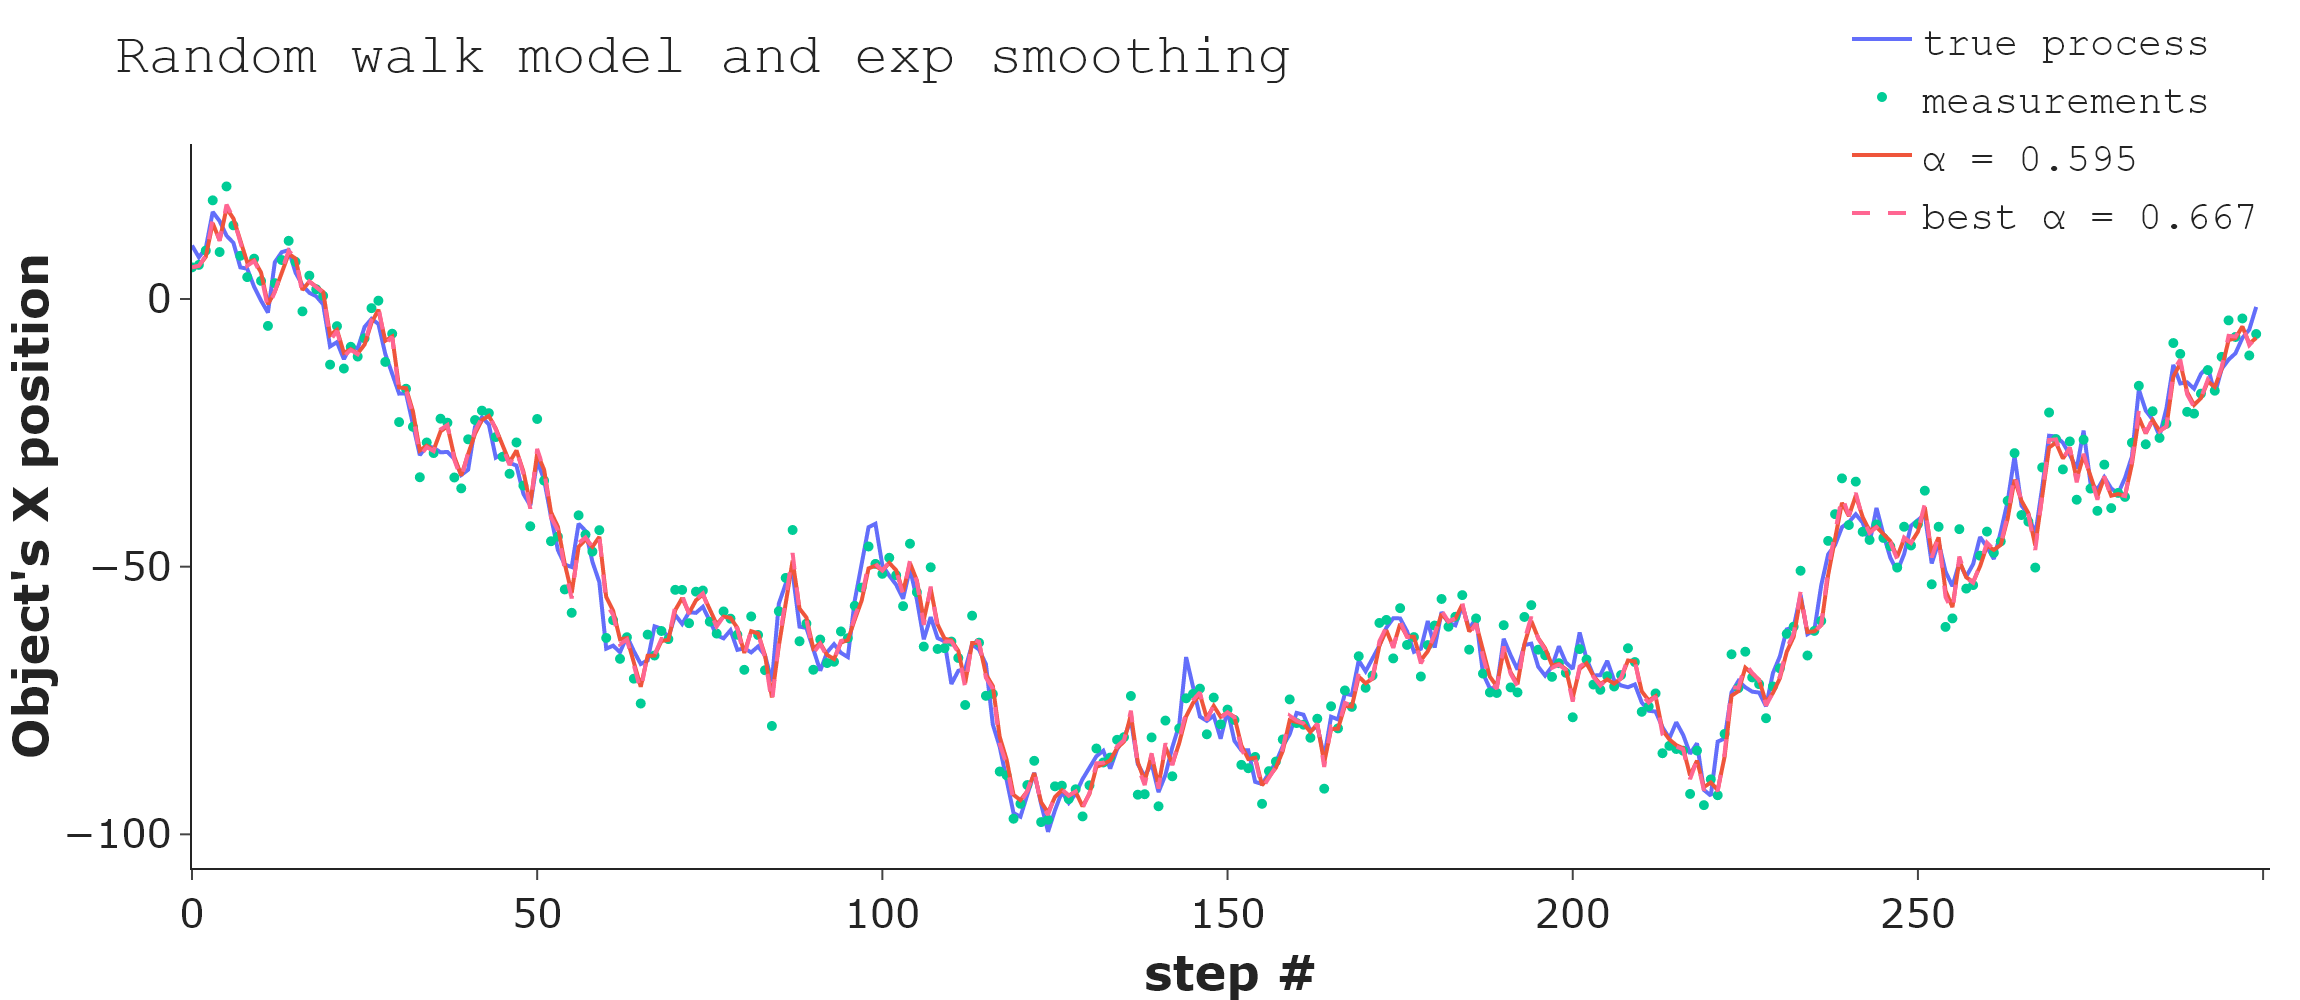

In [151]:
Image('Random walk and smoothing_300.png')

## Figure 1b

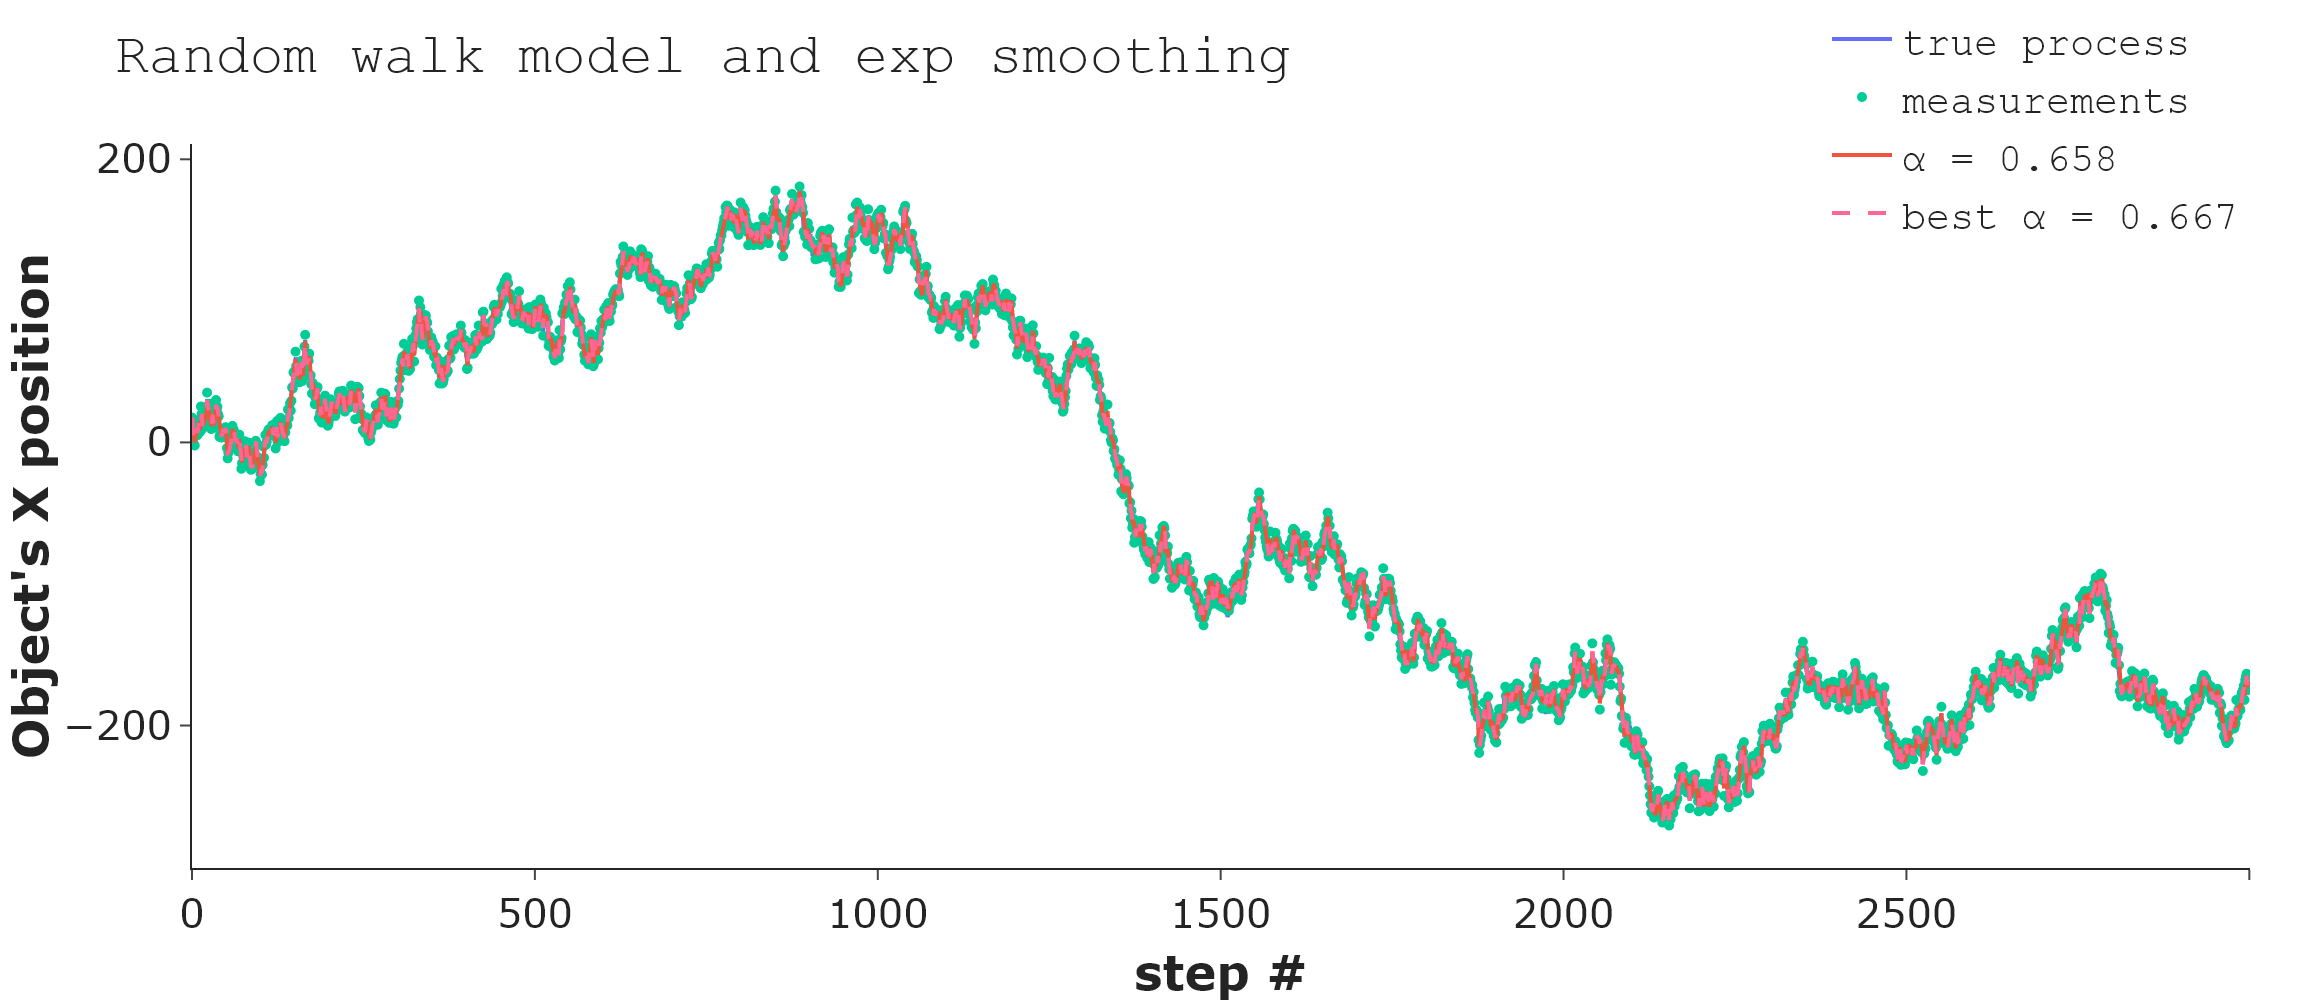

In [152]:
Image('Random walk and smoothing_3000.png')

Comments to figures 1a and b:<br>
Even for 300 sample size differences between smoothing based on estimated optimal alpha and theoretical optimal alpha are insignificant.<br>
Obviously, accuracy of optimal alpha estimation increases with the sample size increase<br><br>

# Part II

Previous steps are repeated with following parameters:<br>
Size of trajectory - 300 points<br>
Initial condition X<sub>2</sub> = 10<br>
Process variance = 28<sup>2</sup> <br>
Process measurement noise = 97<sup>2</sup><br>


## 1. Generating true trajectory

In [113]:
sample_size = 300
y_true = random_walk(sample_size, 10, 28**2)

## 2. Generating measurements

In [102]:
y_meas = measurements(y_true, 97**2)

## 3., 4. Determine optimal smoothing coefficient and window size

If we suppose that there is some optimal smoothing and we can obtain it both by using exponential and running mean smoothing then optimal variances of both smoothing methods should be equal: <br>
<br>

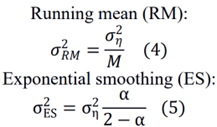 

Hence the formula for *optimal_M(optimal_alpha)* is trivial

In [112]:
def running_mean(data: np.array, window_size: int) -> np.array:
    data_filtered = data.copy()
    window_size = int(window_size)
    for i in range(window_size//2+1, len(data)-window_size//2):
        window = slice(i - window_size//2 - 1, i + window_size//2)
        data_filtered[i] = sum(data[window])/window_size
    return np.array(data_filtered)

def optimal_M(alpha: float) -> int:
    '''Calculates optimal moving window width'''  # that's what we call excessive documentation and typization
    return int(round((2-alpha)/alpha, 0))

In [118]:
optimal_alpha_value = optimal_alpha(*estimate_sigmas(y_meas))
print(f'Smoothing constant: \u03B1 = {optimal_alpha_value:.3f}')
print(f"actual optimal \u03B1 = {optimal_alpha(28**2, 97**2):.3f}")
optimal_m = optimal_M(optimal_alpha_value)
print(f'\nWindow size: M = {optimal_m}')
print(f"actual optimal window size = {optimal_M(optimal_alpha(28**2, 97**2)):d}")

Smoothing constant: α = 0.243
actual optimal α = 0.250

Window size: M = 7
actual optimal window size = 7


### Figure 2. Random walk model with 300 and 3000 step sizes, true trajectory, Exponential smoothing and Running mean smoothing

In [161]:
fig = go.Figure()

sample_size = 300
x = np.arange(sample_size)
y_true = random_walk(sample_size, 10, 28**2)
y_meas = measurements(y_true, 97**2)
y_exp_smooth = exponential_smoothing(y_meas, optimal_alpha_value)
y_opt_exp_smooth = exponential_smoothing(y_meas, optimal_alpha(28**2, 97**2))
y_mov_win_smooth = running_mean(y_meas, optimal_m)
y_opt_mov_win_smooth = running_mean(y_meas, optimal_M(optimal_alpha(28**2, 97**2)))

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_true, name = 'true process', line_color = colors[0]))
fig.add_trace(go.Scatter(x = x, y = y_meas, name = 'measurements', mode="markers", 
                         marker_color = colors[2], marker_size = 3))
fig.add_trace(go.Scatter(x = x, y = y_exp_smooth, 
                         name = f'exp smoothed, <br>\u03b1 = {optimal_alpha_value:.3f}', 
                         line_color = colors[1]))
fig.add_trace(go.Scatter(x = x, y = y_opt_exp_smooth, 
                         name = f'best exp smoothed, <br>\u03b1 = {optimal_alpha(28**2, 97**2):.3f}', 
                         line_color = colors[6], line_dash = 'dash'))
fig.add_trace(go.Scatter(x = x, y = y_mov_win_smooth, 
                         name = f'running mean, <br>M = {optimal_M(optimal_alpha_value):d}', 
                         line_color = colors[4]))
fig.add_trace(go.Scatter(x = x, y = y_opt_mov_win_smooth, 
                         name = f'best running mean, <br>M = {optimal_M(optimal_alpha(28**2, 97**2)):d}', 
                         line_color = colors[9], line_dash = 'dash'))

fig.update_layout(template = 'simple_white', 
                  title = 'Random walk model and exp smoothing',
                  title_font_family = 'Courier',
                  font_size = 20,
                  legend_font_size = 15,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_range = [0, sample_size-1],
                  xaxis_title = 'step #',
                  yaxis_title = "<b>Object's X position</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0.8)',
                  legend_font_family = 'Courier',
                  legend_x = 1,
                  legend_y = 1.2, width = 1150, height = 500)
fig.show()

In [157]:
fig.write_image(f"Random walk and rm smoothing_{sample_size}.png", format = 'png', width = 1150, height = 500, scale = 2)

## Figure 2a

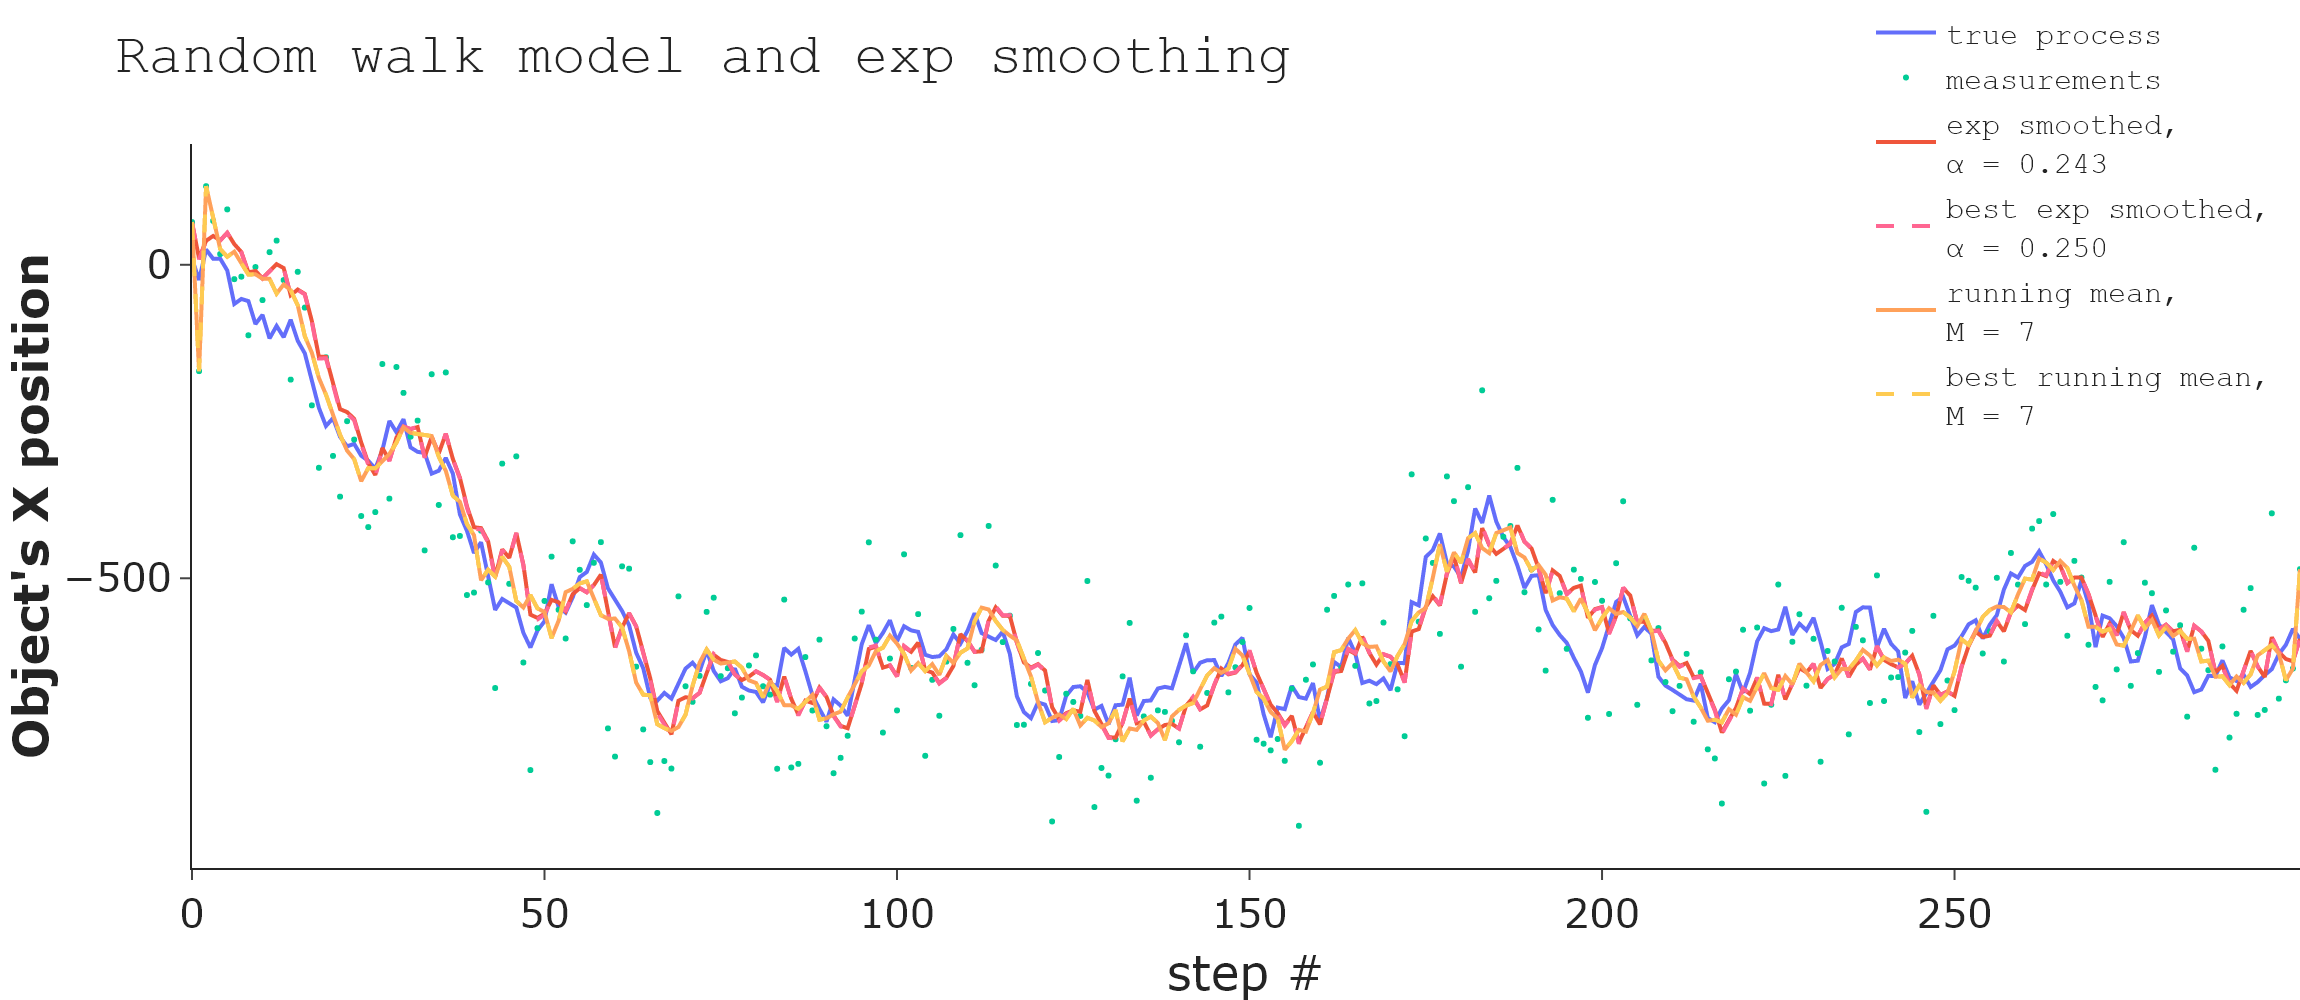

In [158]:
Image('Random walk and rm smoothing_300.png')

## Figure 2b

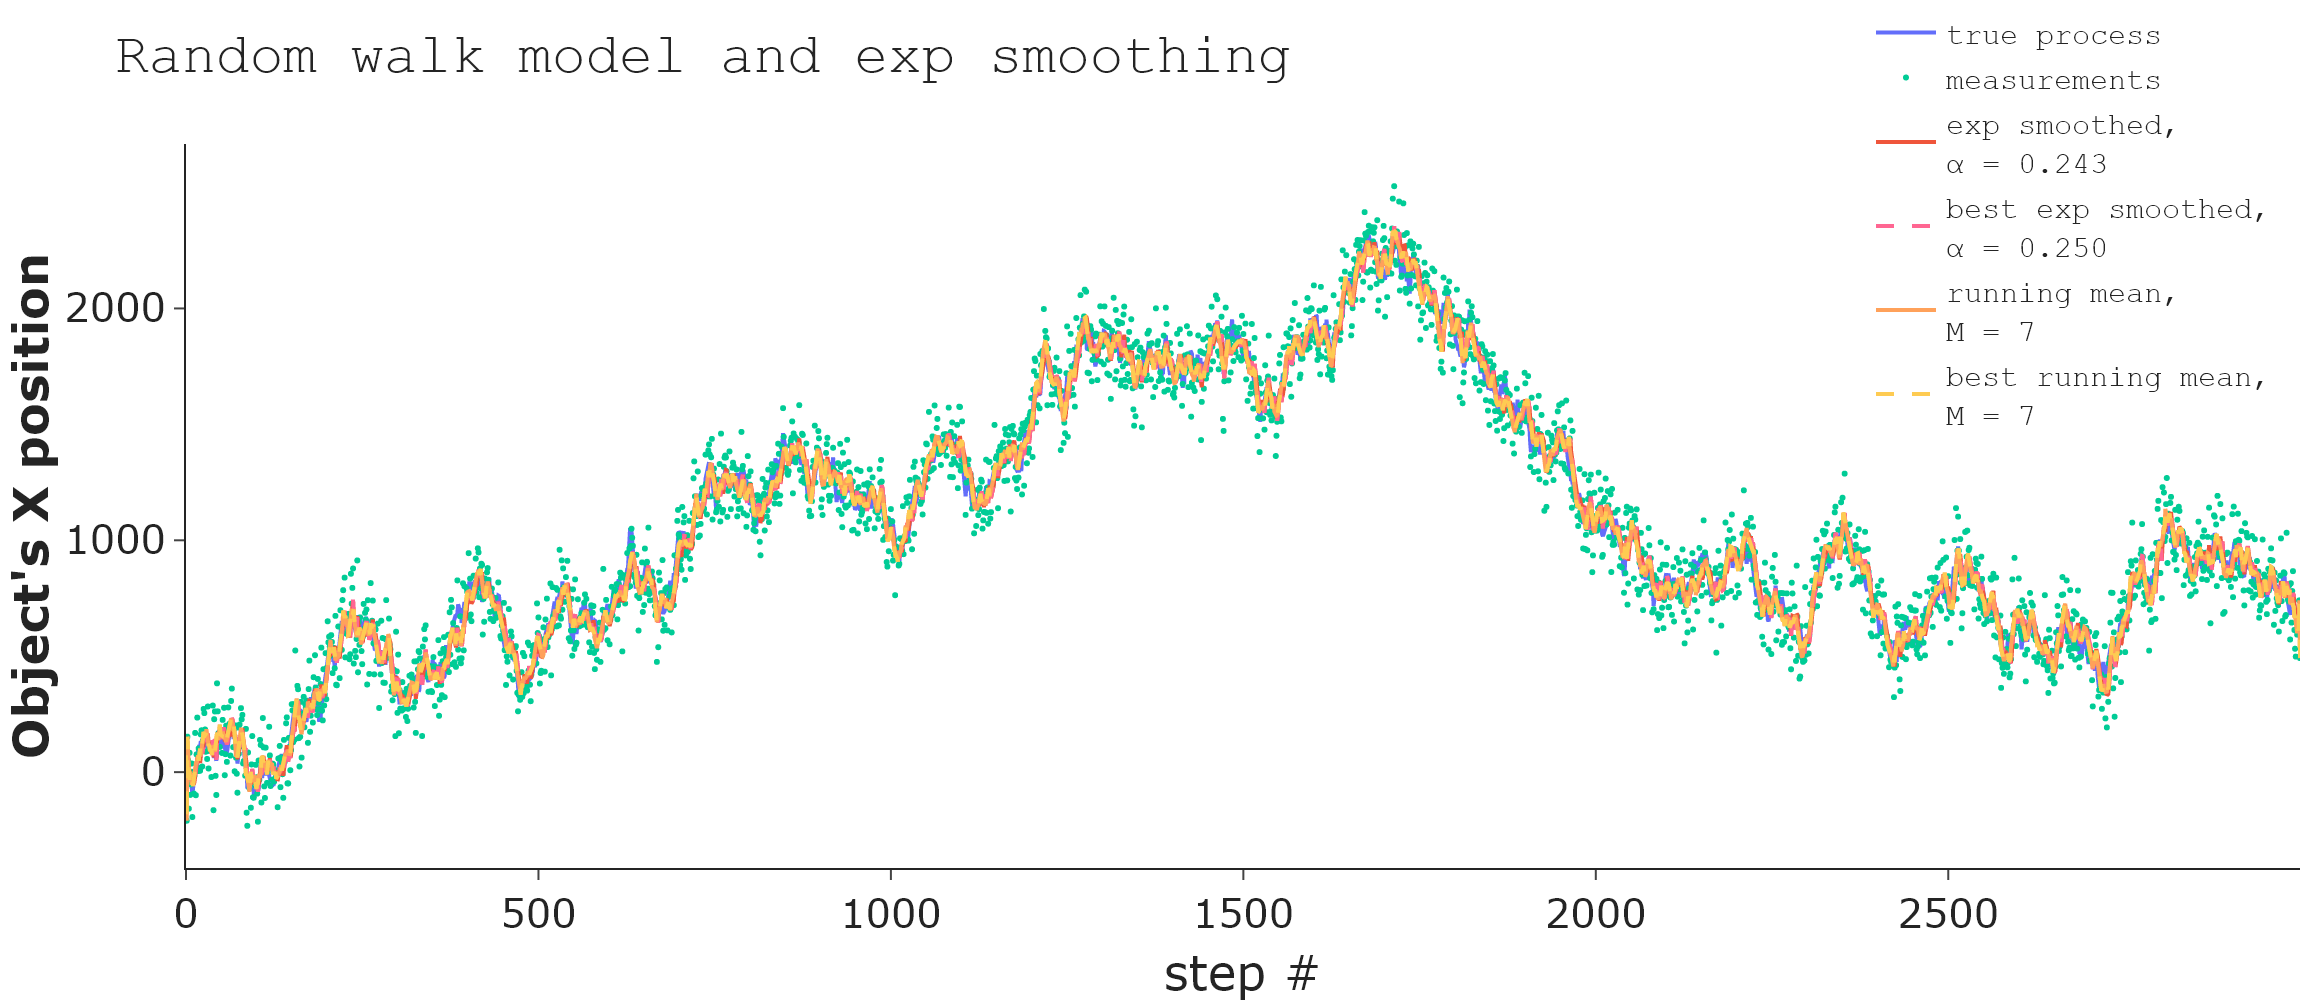

In [159]:
Image('Random walk and rm smoothing_3000.png')

Again, theoretically optimal parameters (alpha, moving_window) for measurements data smoothing and estimated parameters are very close even for low sample sizes.

It is hard to determing the most accurate method based on visual comparison. <br>
Both methods have a "phase shift" problem

# Conclusion

Running mean seems like a very simple method conceptually, <br>
but edge behavior could become a serious issue for large moving window cases <br>
(what to do with data[:window_length//2] and data[-window_length//2:]). <br>
Edge behaviour of moving window methods in general why in packages (numpy, scipy) for all rolling window functions <br>
there's a specified option that simulates head and tail of the data with the length window_length//2. <br>
For example, scipy.signal.savgol_filter has five modes - ‘mirror’, ‘constant’, ‘nearest’, ‘wrap’ or ‘interp’(None)

Exponential mean is a little more sophisticated as it takes into account all previous data (but with weights decreasing exponentially with "time").<br>
Drawbacks of moving average were discussed at lenght in the lecture #2 (inverse variations, loss of variations at particular *window_size*s)  